# Evaluate likelihood ratio

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy.stats import norm
from sklearn.metrics import roc_curve

from simulation.population_sim import SubhaloSimulator
from inference.estimator import ParameterizedRatioEstimator
from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Data

In [2]:
xs = np.load("../data/samples/x_test.npy")

In [11]:
idx = list(range(10,20))
nrows = len(idx)

In [12]:
filenames = ["carl", "alice", "alices"]
labels = ["CARL-18", "ALICE-18", "ALICES-18"]
colors = ["blue", "yellow", "red"]
nmethods = len(filenames)
ncols = 2*len(filenames)

In [13]:
llrs = np.asarray([np.load("../data/results/llr_{}_grid.npy".format(filename)) for filename in filenames])
grads = np.asarray([np.load("../data/results/grad_x_{}_grid.npy".format(filename)) for filename in filenames])
grad_logs = grads * xs[np.newaxis, :grads.shape[1]]
rel_grads = np.abs(grad_logs) / np.sum(np.abs(grad_logs).reshape(grad_logs.shape[0], grad_logs.shape[1], -1), axis=2)[:,:,np.newaxis, np.newaxis]


In [14]:
grid_res = 25

alpha_test = np.linspace(1., 19., grid_res)
beta_test = np.linspace(-1., -2.8, grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

## Plotting options

In [15]:
llrmin, llrmax = -10., 10.
gradmin, gradmax = -0.1, 0.1
gradrelmax = 0.001
xmin, xmax = 2.25, 3.5

llr_cmap = "PRGn_r"


In [16]:
grad_rel = True
alpha_grad = 0.6

if grad_rel:
    grad_rel_color = colorConverter.to_rgba("C1")[:3]

    overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'overlay_cmap',
        [(0., grad_rel_color), (1., grad_rel_color)],
        512
    )
    overlay_cmap._init()
    alphas = np.linspace(0., alpha_grad, overlay_cmap.N + 3)
    overlay_cmap._lut[:,-1] = alphas
    
else:
    pos_grad_color = colorConverter.to_rgba("C0")[:3]
    neg_grad_color = colorConverter.to_rgba("C1")[:3]

    overlay_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'overlay_cmap',
        [(0., neg_grad_color), (0.499, neg_grad_color), (0.501, pos_grad_color), (1., pos_grad_color)],
        512
    )
    overlay_cmap._init()
    alphas = np.asarray(
        list(np.linspace(alpha_grad, 0, overlay_cmap.N // 2 + 1))
        + [0.]
        + list(np.linspace(0., alpha_grad, overlay_cmap.N // 2 + 1))
    )
    overlay_cmap._lut[:,-1] = alphas

## Plot

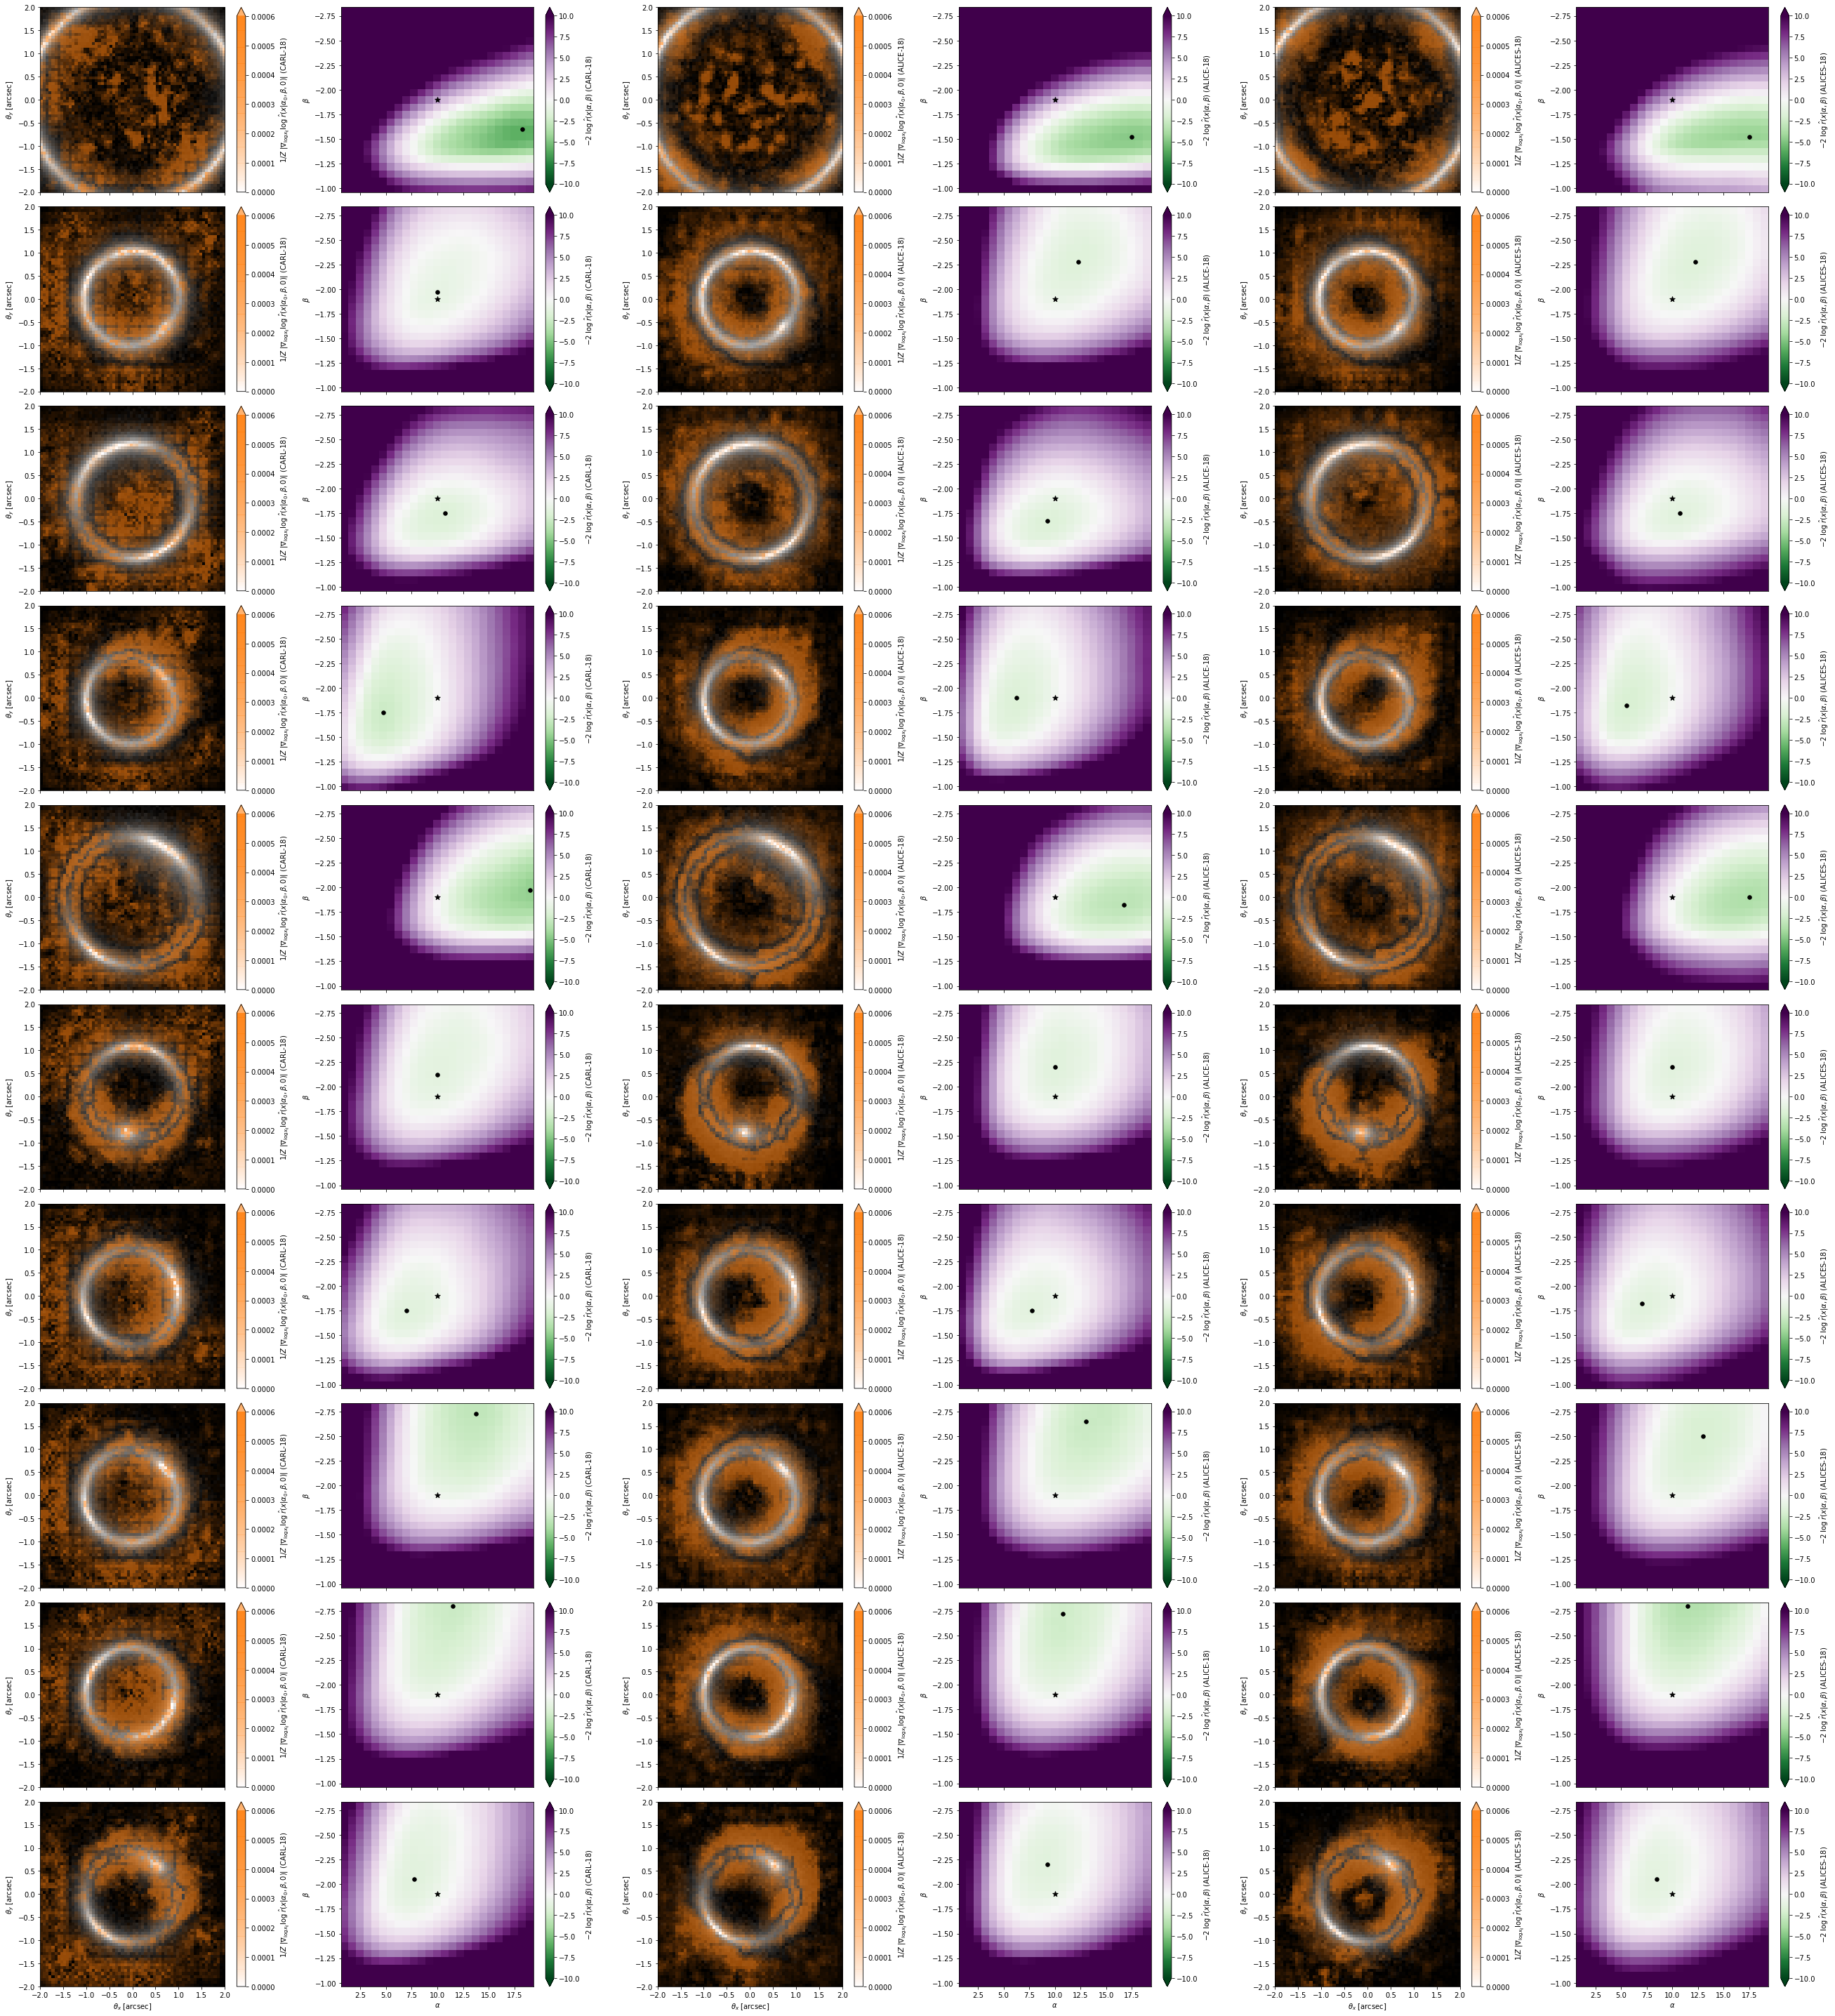

In [18]:
fig = plt.figure(figsize=(6.*ncols, 4*nrows))
ax_xs = []
ax_rs = []

for i in [nrows - 1] + list(range(nrows - 1)):
    for k in range(nmethods):
        i_img = idx[i]
        
        # Plot image
        if i == nrows - 1:
            ax_xs.append(plt.subplot(nrows, ncols, i*ncols + 1 + 2*k))
            ax = ax_xs[-1]
        else:
            ax = plt.subplot(nrows, ncols, i*ncols + 2*k + 1, sharex=ax_xs[k])

        plt.imshow(
            np.log10(xs[i_img]),
            vmin=xmin,
            vmax=xmax,
            cmap='gist_gray',
            extent=(-2.,2.,-2.,2.),
            origin="lower",
            alpha=1.
        )
        if grad_rel:
            im = plt.imshow(
                rel_grads[k][i_img],
                vmin=0.,
                vmax=gradrelmax,
                cmap=overlay_cmap,
                extent=(-2.,2.,-2.,2.),
                origin="lower",
            )
        else:
            im = plt.imshow(
                grad_logs[k][i_img],
                vmin=gradmin,
                vmax=gradmax,
                cmap=overlay_cmap,
                extent=(-2.,2.,-2.,2.),
                origin="lower",
            )
        cbar = fig.colorbar(im, ax=ax, extend='max')

        plt.xlim(-2.,2.)
        plt.ylim(-2.,2.)
        if i == nrows - 1:
            plt.xlabel(r"$\theta_x$ [arcsec]")
        else:
            plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.ylabel(r"$\theta_y$ [arcsec]")
        if grad_rel:
            cbar.set_label(
                r'$1/Z \; |\nabla_{\log x_{ij}} \log \;\hat{r}(x | \alpha_0, \beta,0)|$ ' + '({})'.format(labels[k])
            )
        else:
            cbar.set_label(
                r'$\nabla_{\log x_{ij}} \log \;\hat{r}(x | \alpha_0, \beta,0)$ ' + '({})'.format(labels[k])
            )
    
    
    
        # Plot estimated likelihood ratios
        if i == nrows - 1:
            ax_rs.append(plt.subplot(nrows, ncols, i*ncols + 2*k + 2))
            ax = ax_rs[k]
        else:
            ax = plt.subplot(nrows, ncols, i*ncols + 2*k + 2, sharex=ax_rs[k])
        
        i_mle = np.argmax(llrs[k][:, i_img])
        theta_mle = theta_grid[i_mle]
        z = np.clip(-2. * llrs[k][:, i_img], llrmin, llrmax)
    
        pcm = ax.pcolormesh(
            alpha_edges,
            beta_edges,
            z.reshape((grid_res, grid_res)),
            norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
            cmap=llr_cmap
        )
        cbar = fig.colorbar(pcm, ax=ax, extend='both')
        plt.scatter(10., -1.9, s=60., color='black', marker='*')
        plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

        if i == nrows - 1:
            plt.xlabel(r'$\alpha$')
        else:
            plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.ylabel(r'$\beta$')
        cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
        plt.xlim(alpha_edges[0], alpha_edges[-1])
        plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/predictions.pdf")

## Expected LLR

In [10]:
fig = plt.figure(figsize=(5*ncols, 4*nrows))
ax_rs = []

# Plot image
ax = plt.subplot(1, ncols, i*ncols+1)

plt.imshow(
    np.log10(x_train[i]),
    vmin=xmin,
    vmax=xmax,
    cmap='gist_gray',
    extent=(-2.,2.,-2.,2.),
    origin="lower"
)

for k in range(ncols - 1):
    plt.imshow(
        np.abs(grads[k][i_mles[k],i]),
        vmin=gradmin,
        vmax=gradmax,
        cmap=overlay_cmaps[k],
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )

plt.xlim(-2.,2.)
plt.ylim(-2.,2.)
if i == nrows - 1:
    plt.xlabel(r"$\theta_x$ [arcsec]")
else:
    plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.ylabel(r"$\theta_y$ [arcsec]")
    
    
    
# Plot estimated likelihood ratios
for k in range(ncols - 1):
    ax = plt.subplot(nrows, ncols, i*ncols + k + 2)

    i_mle = np.argmax(llrs[k][:, i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * llrs[k][:, i], llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn_r'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(10., -1.9, s=60., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

    if i == nrows - 1:
        plt.xlabel(r'$\alpha$')
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/expected_llr.pdf")

ValueError: num must be 1 <= num <= 6, not 49

<Figure size 2160x2880 with 0 Axes>